
# Transfer Learning con ResNet18, DenseNet121 y VGG16

In [1]:
# %pip install medmnist

In [2]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights, DenseNet121_Weights, VGG16_Weights
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar dataset
data_flag = 'breastmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

train_dataset = DataClass(split='train', transform=transform, download=True)
val_dataset = DataClass(split='val', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
def get_model(name, num_classes=1):
    if name == 'resnet':
        from torchvision.models import resnet18, ResNet18_Weights
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Linear(in_features, num_classes), nn.Sigmoid())

    elif name == 'densenet':
        from torchvision.models import densenet121, DenseNet121_Weights
        model = densenet121(weights=DenseNet121_Weights.DEFAULT)
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(nn.Linear(in_features, num_classes), nn.Sigmoid())

    elif name == 'vgg':
        from torchvision.models import vgg16, VGG16_Weights
        model = vgg16(weights=VGG16_Weights.DEFAULT)
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(nn.Linear(in_features, num_classes), nn.Sigmoid())

    # Congelar todas las capas excepto la cabeza (fc)
    for param in model.parameters():
        param.requires_grad = False

    # Solo entrenar la cabeza
    if name == 'resnet':
        for param in model.fc.parameters():
            param.requires_grad = True
    elif name == 'densenet':
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif name == 'vgg':
        for param in model.classifier[6].parameters():
            param.requires_grad = True

    return model

In [4]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            labels = labels.float().reshape(-1, 1)
            outputs = model(imgs)
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_class = (y_pred > 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred_class)
    return acc

def train_and_evaluate(model, name, epochs=5):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    best_val_acc = 0
    best_state = None

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for imgs, labels in train_loader:
            labels = labels.float().reshape(-1, 1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_acc = correct / total

        val_acc = evaluate(model, val_loader)
        print(f"[{name}] Epoch {epoch+1}: Loss={total_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        # Guardar el mejor modelo según validación
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    # Restaurar el mejor modelo
    if best_state is not None:
        model.load_state_dict(best_state)

    # Evaluación final en test
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            labels = labels.float().reshape(-1, 1)
            outputs = model(imgs)
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_class = (y_pred > 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class)
    prec = precision_score(y_true, y_pred_class)
    rec = recall_score(y_true, y_pred_class)
    roc_auc = roc_auc_score(y_true, y_pred)

    print(f"\n{name.upper()} Results (Best Val Acc: {best_val_acc:.4f}):")
    print(f"Test Accuracy:  {acc:.4f}")
    print(f"F1 Score:      {f1:.4f}")
    print(f"Precision:     {prec:.4f}")
    print(f"Recall:        {rec:.4f}")
    print(f"AUC-ROC:       {roc_auc:.4f}")

In [5]:
for name in ['resnet', 'densenet', 'vgg']:
    print(f"\nEntrenando modelo: {name.upper()}")
    model = get_model(name)
    train_and_evaluate(model, name, epochs=30)
    # Guardar los modelos entrenados
    torch.save(model.state_dict(), f'{name}_model.pth')


Entrenando modelo: RESNET
[resnet] Epoch 1: Loss=10.6837, Train Acc=0.7161, Val Acc=0.6795
[resnet] Epoch 2: Loss=9.6325, Train Acc=0.7381, Val Acc=0.7308
[resnet] Epoch 3: Loss=10.1166, Train Acc=0.7363, Val Acc=0.7436
[resnet] Epoch 4: Loss=9.2926, Train Acc=0.7601, Val Acc=0.7308
[resnet] Epoch 5: Loss=9.1283, Train Acc=0.7582, Val Acc=0.7821
[resnet] Epoch 6: Loss=8.8163, Train Acc=0.7839, Val Acc=0.7564
[resnet] Epoch 7: Loss=8.8295, Train Acc=0.7949, Val Acc=0.7949
[resnet] Epoch 8: Loss=8.1308, Train Acc=0.7875, Val Acc=0.7821
[resnet] Epoch 9: Loss=8.1367, Train Acc=0.7985, Val Acc=0.7949
[resnet] Epoch 10: Loss=9.1675, Train Acc=0.7875, Val Acc=0.8077
[resnet] Epoch 11: Loss=8.7124, Train Acc=0.8187, Val Acc=0.7821
[resnet] Epoch 12: Loss=7.6622, Train Acc=0.8059, Val Acc=0.7821
[resnet] Epoch 13: Loss=8.4667, Train Acc=0.8059, Val Acc=0.8205
[resnet] Epoch 14: Loss=7.5861, Train Acc=0.8095, Val Acc=0.7692
[resnet] Epoch 15: Loss=7.2974, Train Acc=0.8370, Val Acc=0.8077
[resn

In [11]:
def collect_metrics_and_curves(model_names, loader):
    results = []
    for model_name in model_names:
        m = get_model(model_name)
        m.load_state_dict(torch.load(f'{model_name}_model.pth'))
        m.eval()
        y_true, y_pred, y_score = [], [], []
        with torch.no_grad():
            for imgs, labels in loader:
                labels = labels.float().reshape(-1, 1)
                outputs = m(imgs)
                y_true.extend(labels.numpy())
                y_score.extend(outputs.numpy())
                y_pred.extend((outputs > 0.5).int().numpy())
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_score = np.array(y_score)

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_score)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_score)
        pr_auc = auc(recall_curve, precision_curve)
        cm = confusion_matrix(y_true, y_pred)
        fpr, tpr, _ = roc_curve(y_true, y_score)

        results.append({
            'model_name': model_name,
            'y_true': y_true,
            'y_pred': y_pred,
            'y_score': y_score,
            'accuracy': acc,
            'f1': f1,
            'precision': prec,
            'recall': rec,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'confusion_matrix': cm,
            'fpr': fpr,
            'tpr': tpr,
            'precision_curve': precision_curve,
            'recall_curve': recall_curve
        })
    return results

metricas_por_modelo = collect_metrics_and_curves(['resnet', 'densenet', 'vgg'], test_loader)


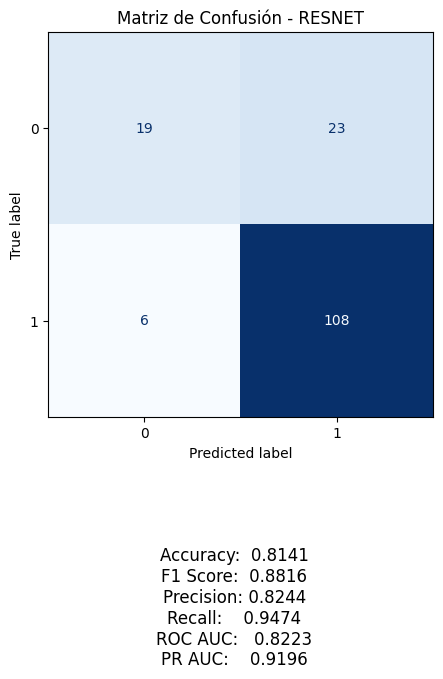

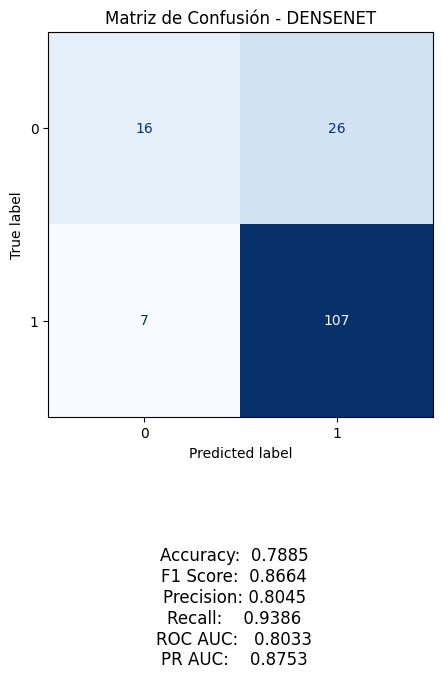

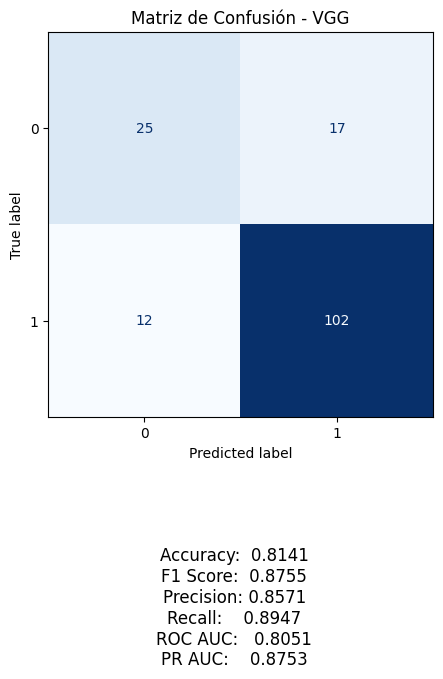

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

for met in metricas_por_modelo:
    model_name = met['model_name']
    cm = met['confusion_matrix']
    acc = met['accuracy']
    f1 = met['f1']
    prec = met['precision']
    rec = met['recall']
    roc_auc = met['roc_auc']
    pr_auc = met['pr_auc']

    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    plt.title(f"Matriz de Confusión - {model_name.upper()}")

    # Texto de métricas bajo la matriz
    metrics_text = (
        f"Accuracy:  {acc:.4f}\n"
        f"F1 Score:  {f1:.4f}\n"
        f"Precision: {prec:.4f}\n"
        f"Recall:    {rec:.4f}\n"
        f"ROC AUC:   {roc_auc:.4f}\n"
        f"PR AUC:    {pr_auc:.4f}"
    )
    plt.gcf().text(0.5, -0.15, metrics_text, fontsize=12, ha='center', va='top')
    plt.show()

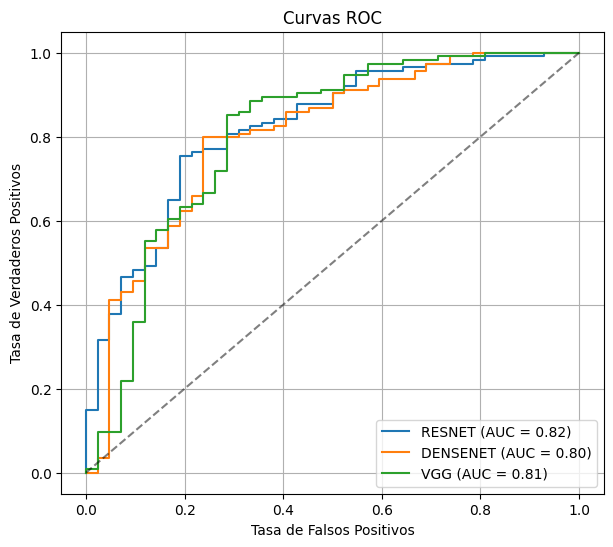

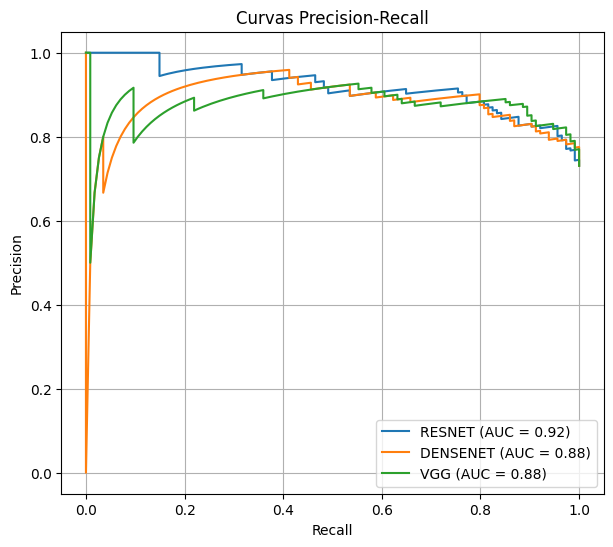

In [13]:
import matplotlib.pyplot as plt

# Curvas ROC
plt.figure(figsize=(7, 6))
for met in metricas_por_modelo:
    plt.plot(met['fpr'], met['tpr'], label=f"{met['model_name'].upper()} (AUC = {met['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend()
plt.grid(True)
plt.show()

# Curvas Precision-Recall
plt.figure(figsize=(7, 6))
for met in metricas_por_modelo:
    plt.plot(met['recall_curve'], met['precision_curve'], label=f"{met['model_name'].upper()} (AUC = {met['pr_auc']:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision-Recall')
plt.legend()
plt.grid(True)